Author: Lijing Wang (lijing52@stanford.edu), 2022

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-training2/code/Users/UQ_surface"
sys.path.append(path) # might change this path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skfmm
import os

from methods.implicit_perturb_2D import *

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelpad'] = 10

# Load intrusion data

## Truth intrusion

In [2]:
truth= np.load(path+'/data/Case2_intrusion/2D_truth.npy')

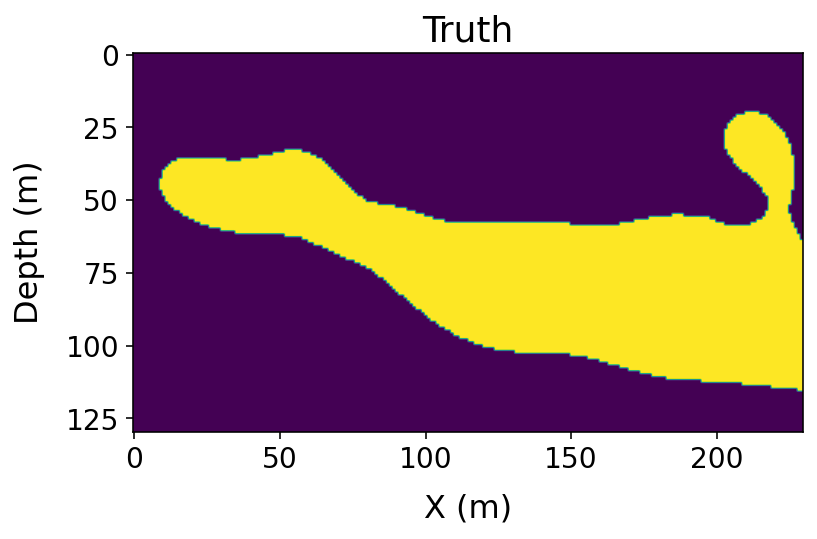

In [3]:
plt.imshow(truth)
plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

## Intrusion boreholes

In [4]:
borehole = pd.read_csv(path+'/data/Case2_intrusion/hole_contacts_UQ.csv')

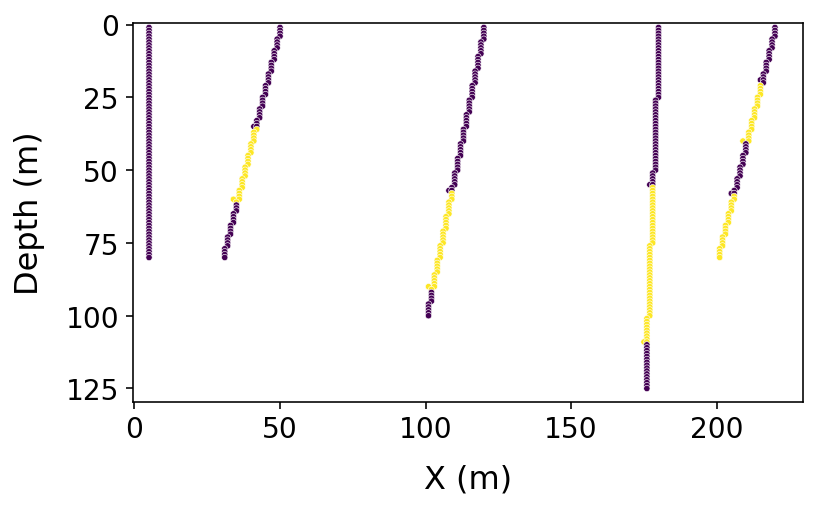

In [5]:
plt.imshow(truth, alpha = 0)
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

## Initial model 

In [6]:
x_dim, y_dim= truth.shape

x0 = 65; a = 20  # x center, half width                                       
y0 = 115; b = 110  # y center, half height   

x = np.linspace(0, x_dim,x_dim)[:,None]  # x values of interest
y = np.linspace(0, y_dim,y_dim)[:]  # y values of interest, as a "column" array
ellipsoid = (((x-x0)/a)**2 + ((y-y0)/b)**2) <= 1  # True for points inside the ellipse
initial = ellipsoid*1

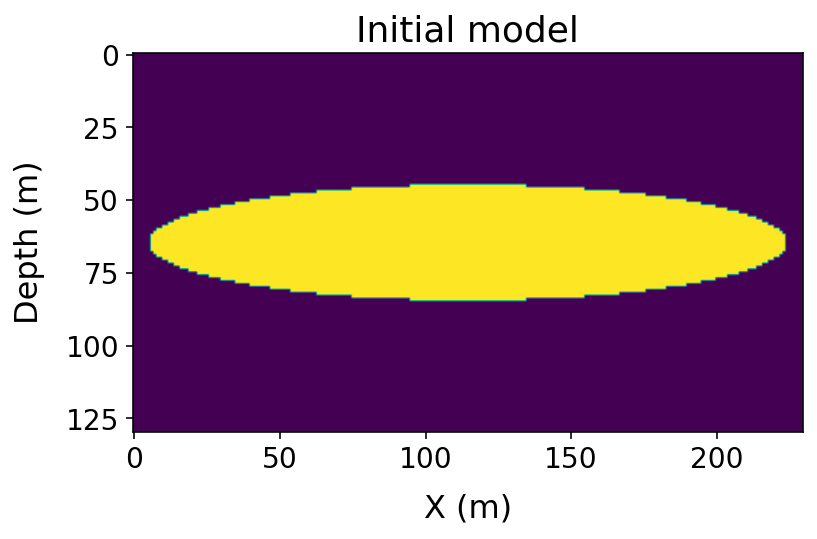

In [7]:
plt.imshow(initial)
plt.title('Initial model')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

# Trend estimation: MCMC on level sets M(x)

In [10]:
data = np.zeros(initial.shape)
data[:] = np.nan
data[np.array(borehole['depth'],dtype = 'int64'),np.array(borehole['x'],dtype = 'int64')]= truth[np.array(borehole['depth'],dtype = 'int64'),np.array(borehole['x'],dtype = 'int64')]#actual data
data[np.array(borehole[borehole['contacts']==1]['depth'],dtype = 'int64'),
     np.array(borehole[borehole['contacts']==1]['x'],dtype = 'int64')] = 0.5 # contact points

In [9]:
# initialized with the signed distance function 
initial = initial - 0.5
model = skfmm.distance(initial)

In [16]:
indicators_x_alpha = data[np.isfinite(data)]
indicators_x_alpha[indicators_x_alpha==0.5]=1

## signed dist at each borehole locations x_alpha
phi_x_alpha_ini = model[np.isfinite(data)]

## signed dist at contact locations x_beta
phi_x_beta_ini = model[data==0.5]

# calculate the loss 
loss_prev, o_ik_prev, o_bias_prev, o_var_prev =  loss_mean_function_v2(indicators_x_alpha,phi_x_alpha_ini,phi_x_beta_ini, model, data)
print(loss_prev)
sigma_coeff = 0.01
print('sigma = ', loss_prev*sigma_coeff)
print(o_ik_prev, o_bias_prev, o_var_prev)

1716.187712354662
sigma =  17.16187712354662
1361.1411111667549 51.7516735492797 303.29492763862737


In [ ]:
iter_num = 30000
[model_cache, loss_cache, para_cache] = McMC_levelsets_2Dv2(model, data, 
                                                loss_function=loss_mean_function_v2,  
                                                sigma = 15, t_step = 1, iter_num = iter_num, 
                                                vel_range_x = [50, 100], vel_range_y = [50, 100],
                                                anisotropy_ang = [0, 180], num_mp = 0)
# np.save('loss_cache.npy',loss_cache)
# np.save('model_cache.npy',model_cache)
# np.save('para_cache.npy',para_cache)

In [18]:
loss_cache = np.load(path+'/results/Case2_intrusion/loss_cache.npy')
model_cache = np.load(path+'/results/Case2_intrusion/model_cache.npy')
para_cache = np.load(path+'/results/Case2_intrusion/para_cache.npy')

In [ ]:
# # You can run multiple chains using this code block
# import multiprocessing
# iter_num = 30000

# sigma = 15
# input_list = [[model, data, loss_mean_function_v2, sigma,  1, iter_num, [20,50], [20,50],  [0,180], 13],
#               [model, data, loss_mean_function_v2, sigma, 1, iter_num, [20,50], [20,50], [0,180], 14],
#               [model, data, loss_mean_function_v2, sigma,  1, iter_num, [30,75], [30,75], [0,180], 15],
#               [model, data, loss_mean_function_v2, sigma, 1, iter_num, [30,75], [30,75], [0,180], 16],
#               [model, data, loss_mean_function_v2, sigma,  1, iter_num, [50,100], [50,100], [0,180], 17],
#               [model, data, loss_mean_function_v2, sigma, 1, iter_num, [50,100], [50,100], [0,180], 18]]

# # Trend estimation, McMC
# # 6 runs
# # the start indicate where we retrieve our velocity
# if __name__ == '__main__':
#     pool = multiprocessing.Pool(processes = 6)
#     result = pool.map(mp_non_stationary_implicit_2D,input_list)
#     pool.close()

In [ ]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

## Trace plot

Text(0, 0.5, 'Loss')

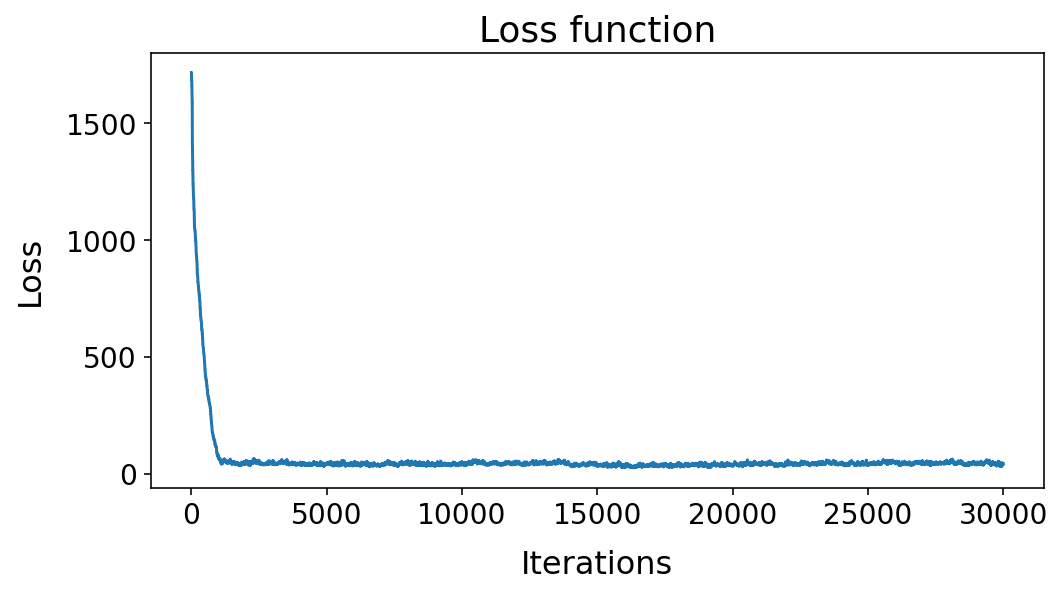

In [36]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [56]:
para_cache[para_cache==-1] = np.nan

Text(0, 0.5, 'Loss')

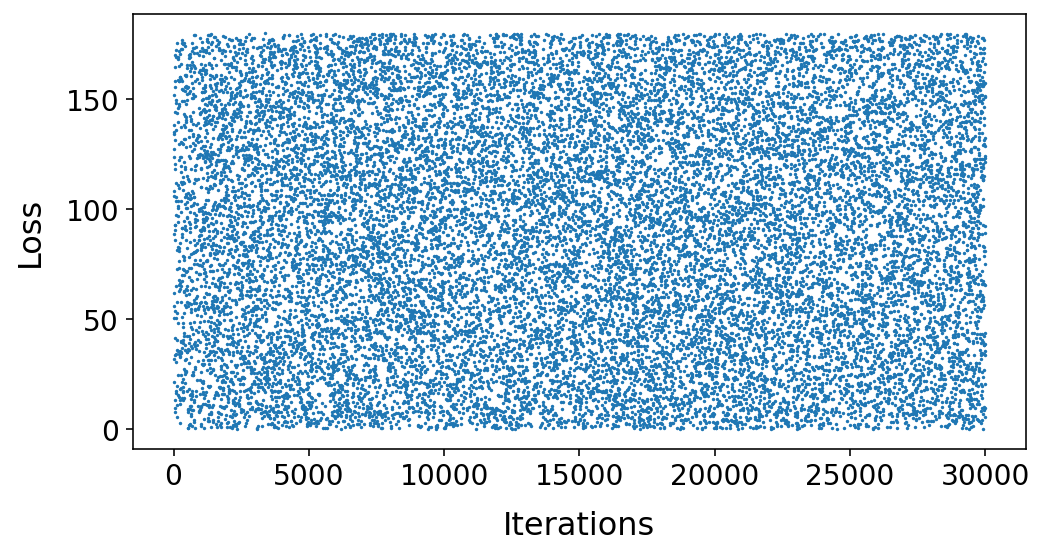

In [80]:
#plt.rcParams["figure.figsize"] = (8, 4) 
plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
#plt.plot(para_cache[:,1],'.')
#plt.hist(para_cache[:,2])
#plt.hist(para_cache[:,3])
#plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Mean and variance

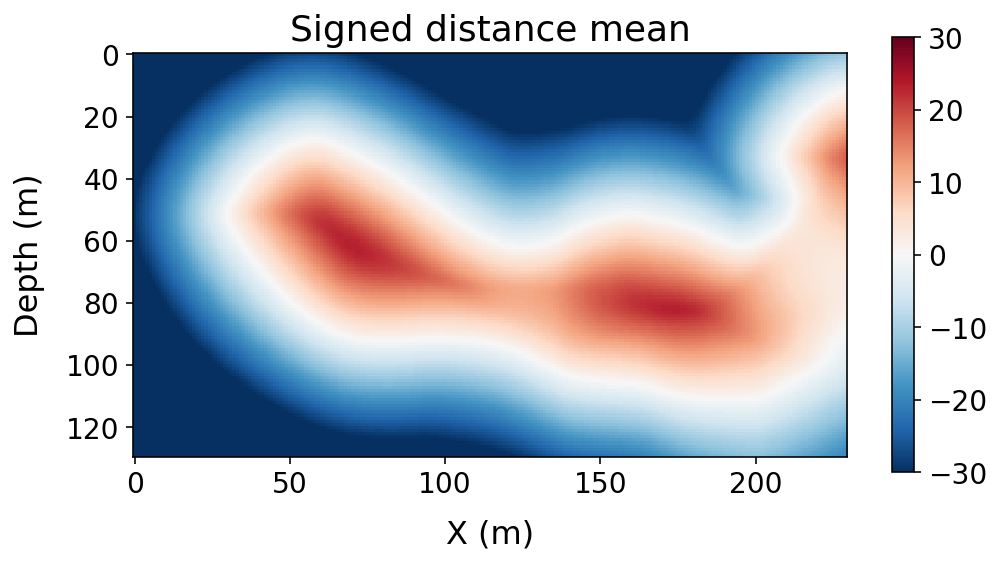

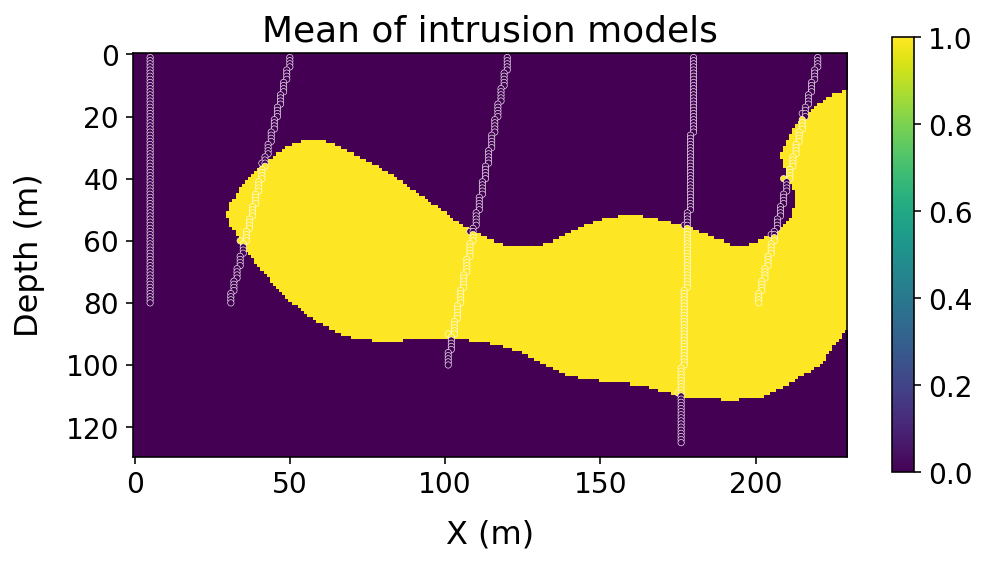

In [44]:
plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0)>0)
plt.colorbar()
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Mean of intrusion models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

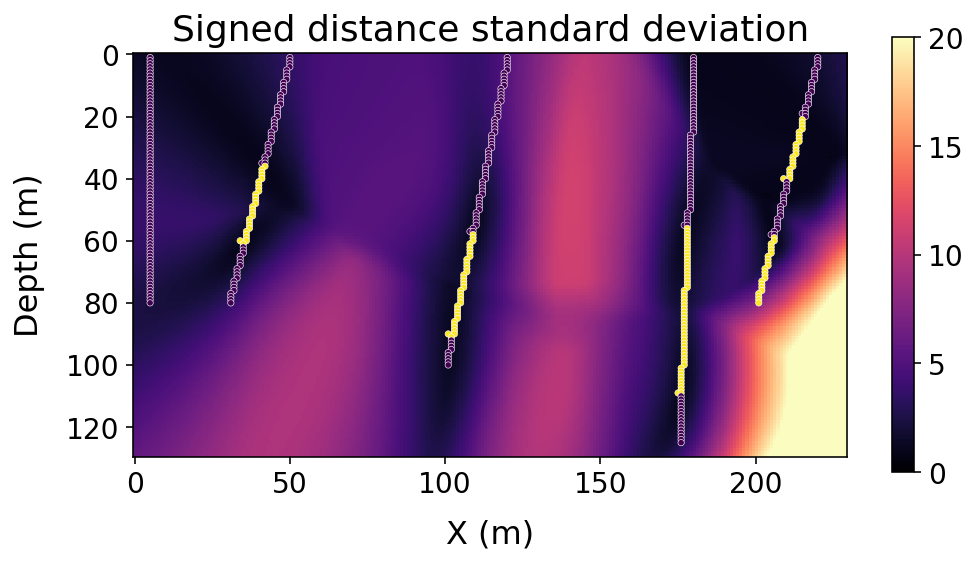

In [39]:
plt.imshow(np.std(model_cache[1000:,:,:],axis = 0),vmin = 0,vmax = 20, cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

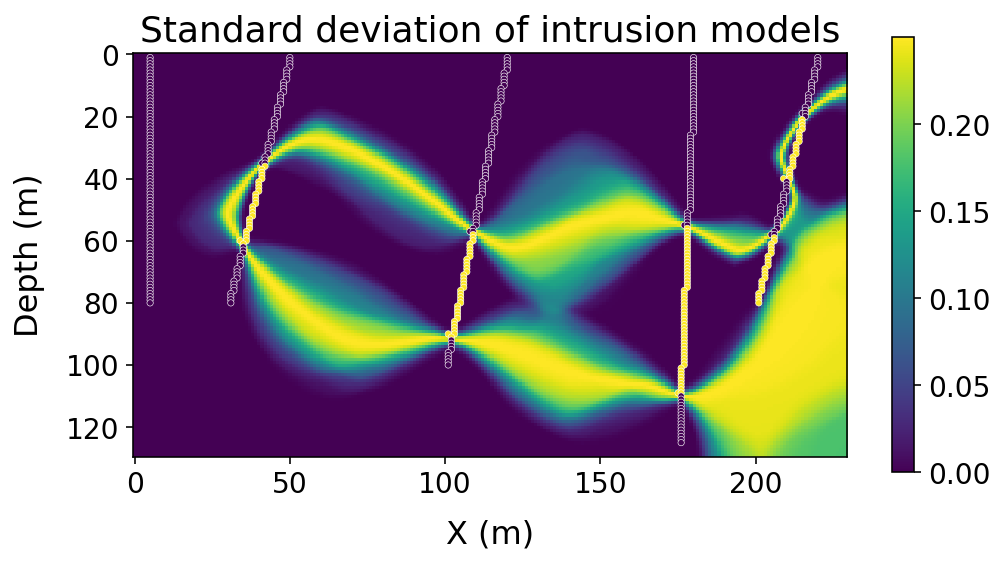

In [45]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [46]:
# plt.imshow((np.mean(model_cache[1000:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0))>0)
# plt.colorbar()
# plt.title('Signed distance standard deviation')
# plt.scatter(borehole['x'], borehole['depth'],
#             c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
# plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
# plt.show()

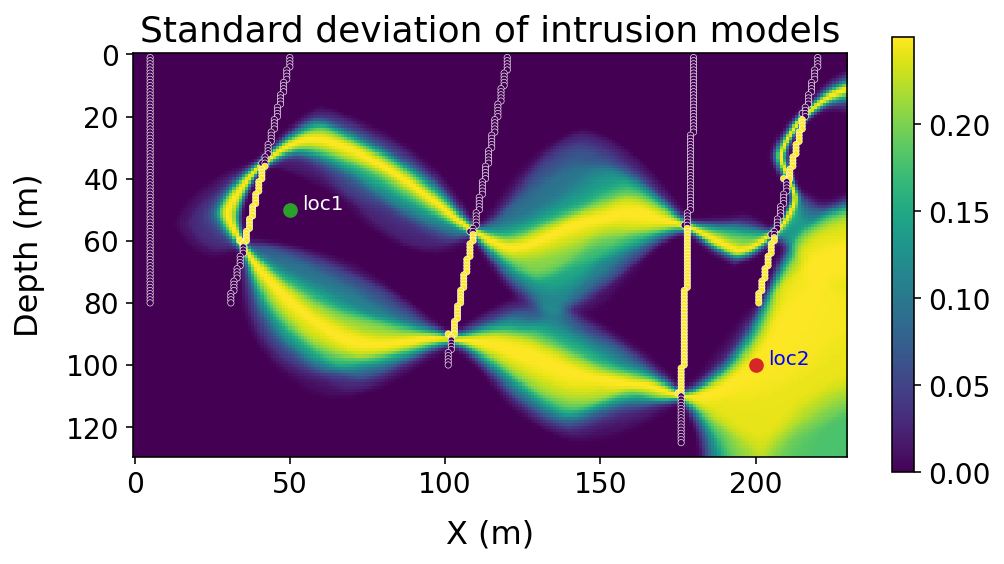

In [119]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)

plt.scatter(50,50,c = 'C2',s = 40)
plt.text(50+4,50,'loc1',color = 'w')
plt.scatter(200,100,c = 'C3',s = 40)
plt.text(200+4,100,'loc2',color = 'b')

plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

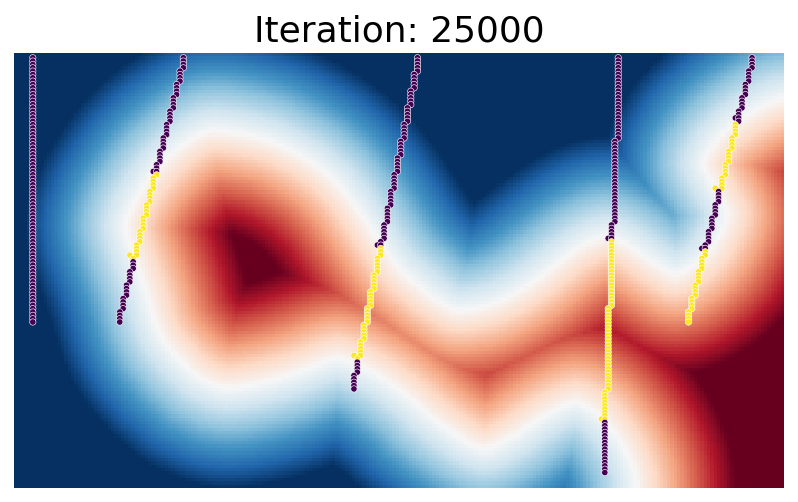

In [475]:
idx = 25000
plt.imshow(model_cache[idx,:,:],vmin = -30,vmax =30,cmap = 'RdBu_r')
#plt.colorbar()
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Iteration: '+str(idx))
#plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.axis('off')
plt.show()

## Convergence

In [81]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

Text(0.5, 1.0, 'Trace plot')

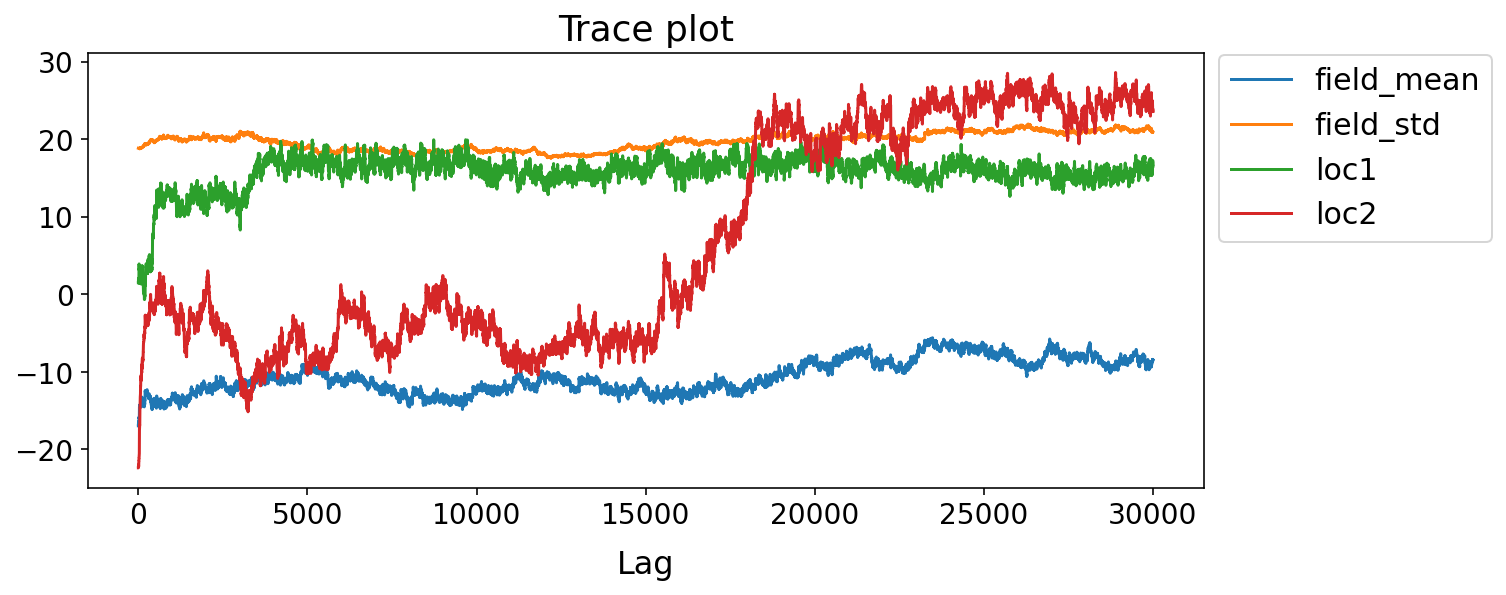

In [122]:
iter_num = 30000
model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(model_cache_mean,label = 'field_mean')
plt.plot(model_cache_std,label = 'field_std')

plt.plot(model_cache[:,50,50],label = 'loc1')
plt.plot(model_cache[:,100,200],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

## ACF

In [133]:
cut_off = 2000
from statsmodels.tsa.stattools import acf
acf_values = np.zeros((10001,model_cache.shape[1],model_cache.shape[2]))
for i in tqdm(range(model_cache.shape[1])):
    for j in range(model_cache.shape[2]):
        acf_values[:,i,j] = acf(model_cache[cut_off:,i,j],nlags = 10000)

100%|██████████| 130/130 [01:48<00:00,  1.20it/s]


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

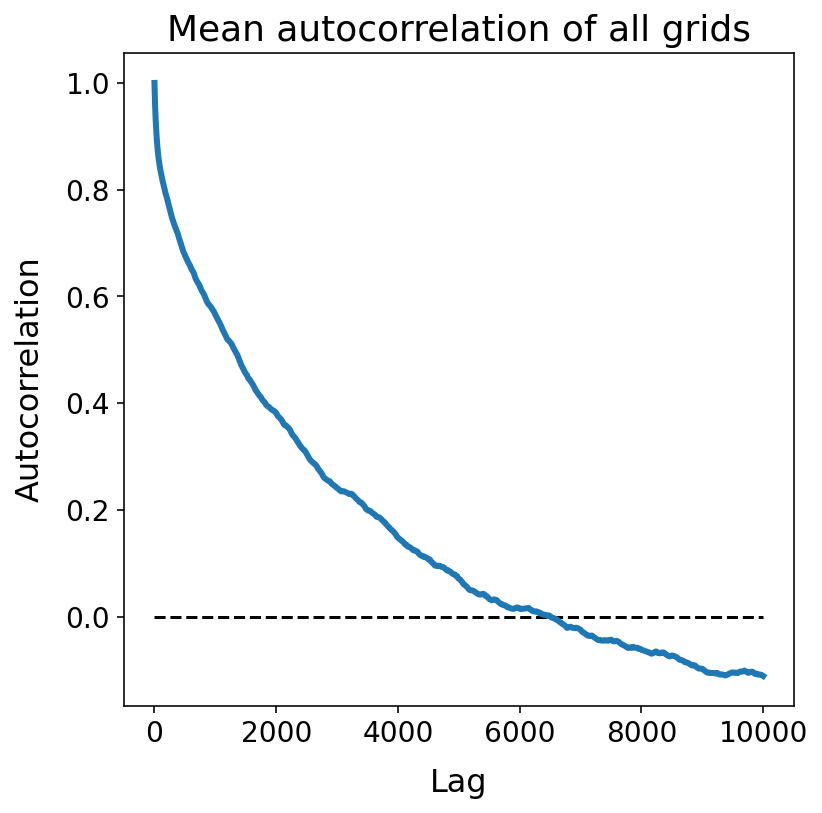

In [135]:
plt.rcParams["figure.figsize"] = (6, 6) 
plt.plot(np.mean(acf_values.reshape(10001,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 10000,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

In [136]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

Text(0.5, 1.0, 'Acceptance rate')

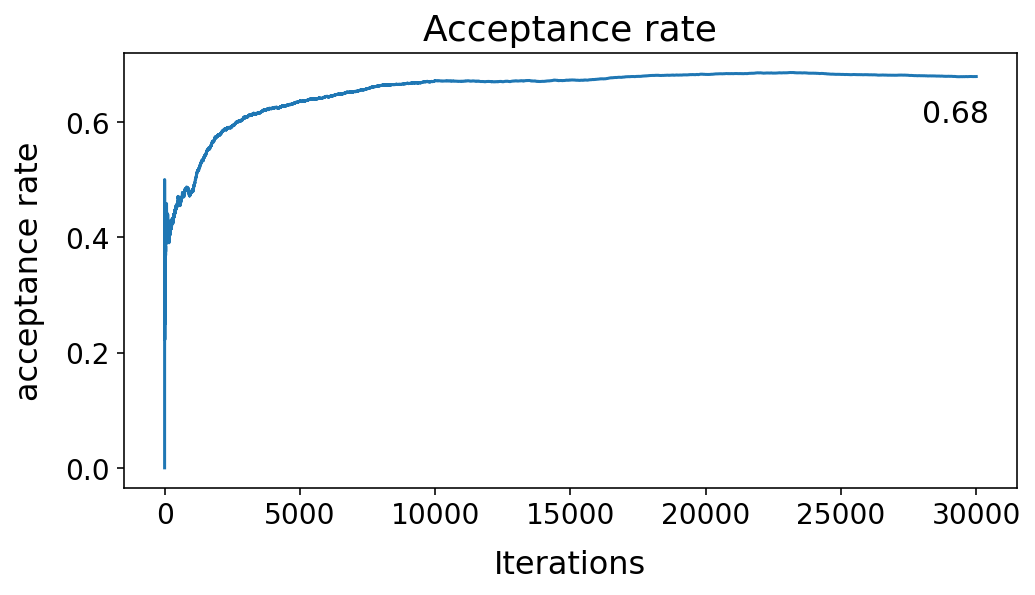

In [139]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.5+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

# Residual simulation, velocity extension on each trend

## Step 1: Calculate the signed distance for each contact point in our data

In [160]:
idx_at_contact = np.abs(np.gradient(data,axis = 0))>0

In [166]:
mc_pos_sdf = np.copy(model_cache[cut_off:,:,:])
sdf_at_contact = np.zeros((mc_pos_sdf.shape[0],np.sum(idx_at_contact)))
for i in tqdm(range(mc_pos.shape[0])):
    #mc_pos_sdf[i,:,:] = skfmm.distance(mc_pos[i,:,:]-0.5)
    sdf_at_contact[i,:] = mc_pos_sdf[i,:,:][idx_at_contact]

100%|██████████| 28000/28000 [00:00<00:00, 116821.48it/s]


Text(0.5, 1.0, 'Histogram of signed distance at the contact points')

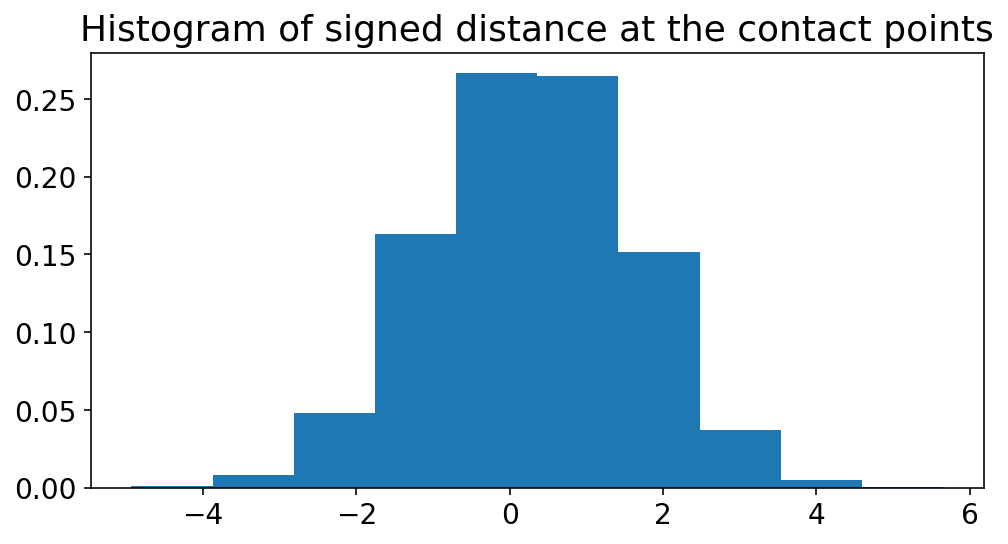

In [169]:
plt.hist(sdf_at_contact.reshape(-1),density = True)
plt.title('Histogram of signed distance at the contact points')

In [463]:
plus_pos = mc_pos_sdf[:,data==1]
minus_pos = mc_pos_sdf[:,data==0]

Text(0.5, 1.0, 'Borehole accuracy')

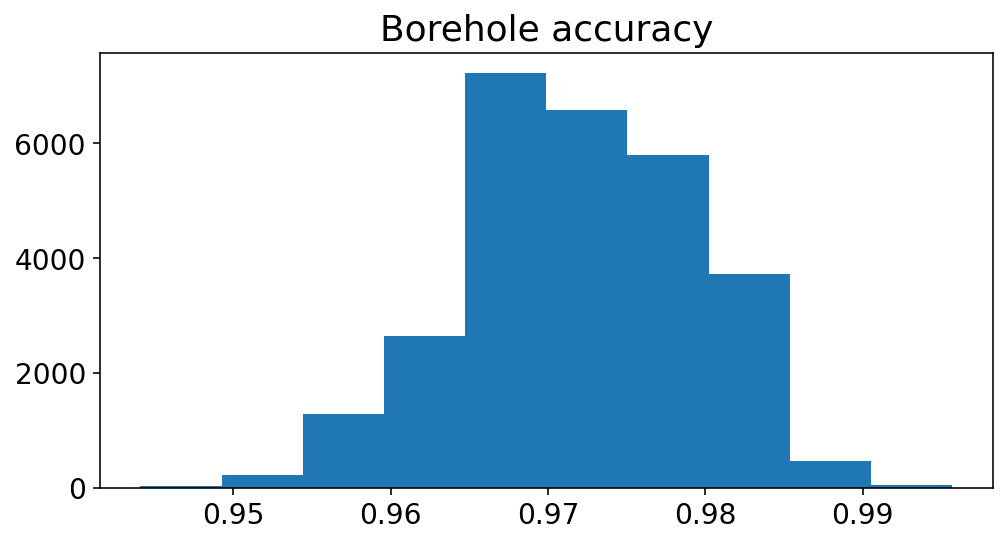

In [464]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0,axis = 1)+np.sum(minus_pos<0,axis = 1))/(np.sum(data==0)+np.sum(data==1)))
plt.title('Borehole accuracy')

## Step 2: M(x) + R(x), Construct velocity with the above variance and do velocity extension

In [170]:
variance = np.var(sdf_at_contact.reshape(-1))

In [171]:
def extension_with_large_velocity(model):
    nx, ny = model.shape
    velocity = generate_m_2D([0,variance,20,20, np.random.uniform(0,180)], np.arange(nx), np.arange(ny), seed = None)
    # Here I choose the range 20 because trend can capture large scale variances larger than 20. 
    [_, F_eval] = skfmm.extension_velocities(model, velocity, dx=[1, 1],order = 1)
    
    max_iter_num = np.int(np.ceil(np.max(np.abs(F_eval))))
    for ii in range(max_iter_num):
        dt = 1/np.ceil(np.max(np.abs(F_eval)))
        delta_phi = dt * F_eval
        model_next = model - delta_phi # Advection
        model = skfmm.distance(model_next)
    return model

In [175]:
mc_pos_sdf_selected = model_cache[np.arange(cut_off,iter_num,100),:,:]

In [176]:
mc_pos_sdf_plus_residual = np.zeros(mc_pos_sdf_selected.shape)
for i in tqdm(range(mc_pos_sdf_selected.shape[0])):
    mc_pos_sdf_plus_residual[i,:,:] = extension_with_large_velocity(mc_pos_sdf_selected[i,:,:])

  0%|          | 0/280 [00:00<?, ?it/s]/tmp/ipykernel_3872251/1219489266.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter_num = np.int(np.ceil(np.max(np.abs(F_eval))))
100%|██████████| 280/280 [05:22<00:00,  1.15s/it]


## Step 3:  M(x) + R(x) with perfect match, Ensemble smoother for final matches

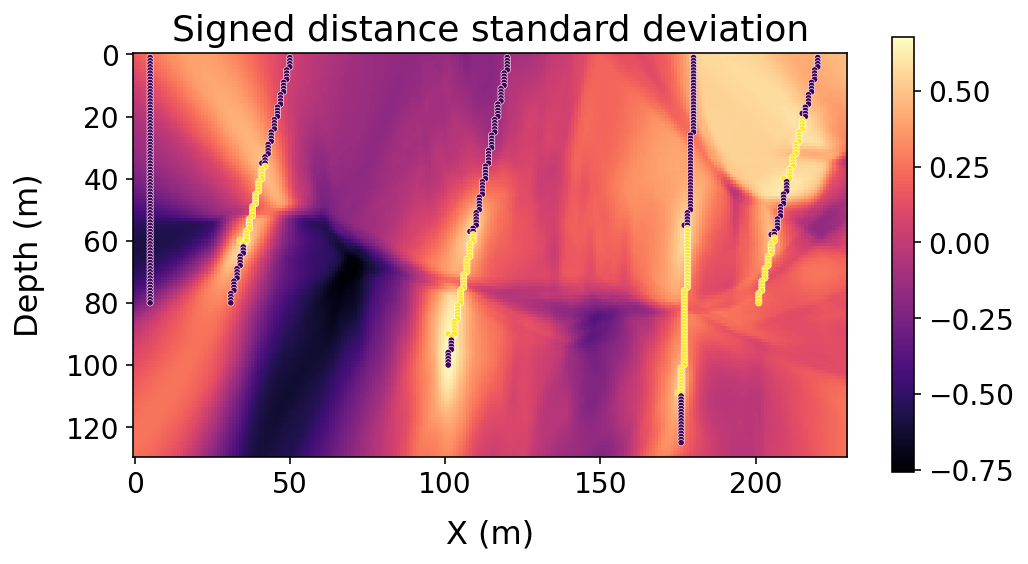

In [182]:
plt.imshow(np.std(mc_pos_sdf_plus_residual[:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0), cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

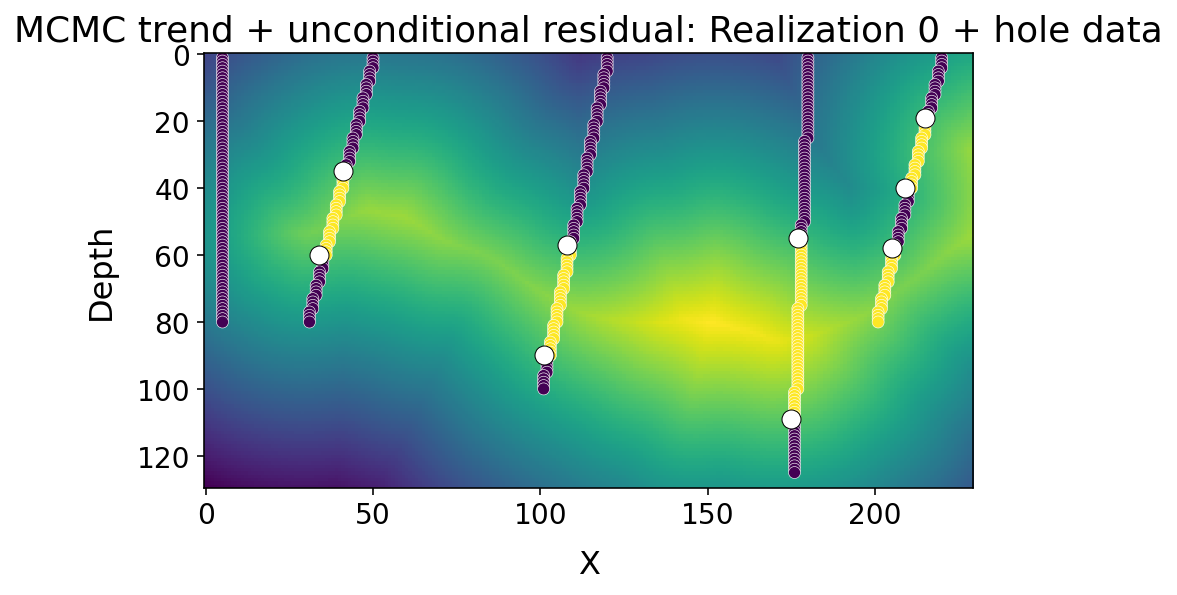

In [179]:
idx = 0
plt.imshow(mc_pos_sdf_plus_residual[idx,:,:])
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
plt.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)

plt.title('MCMC trend + unconditional residual: Realization '+str(idx)+' + hole data')
plt.ylabel('Depth'), plt.xlabel('X')
plt.show()

In [432]:
# Sigmoid on DT
def sigmoid(prior_DT):
    return 1/(1 + np.exp(-prior_DT*10))

def ensemble_smoother(m,d,d_obs):
    # no measurement error for now
    # covaraince matrix of d: cov_d
    cov_d = np.cov(d)
    # cross-covariance matrix: cov_m_d, m can be very large so I split into small piece and calculate the covariance matrix.
    start = 0
    sep = 1000
    cov_m_d = np.zeros((m.shape[0],d.shape[0]))
    for end in np.arange(0,m.shape[0],sep)+sep:
        cov_m_d[start:end,:] = np.cov(m[start:end,:],d)[:m[start:end,:].shape[0],m[start:end,:].shape[0]:]
        start = end

    K = np.dot(cov_m_d, np.linalg.inv(cov_d))
    m_pos = m + np.dot(K,d_obs-d)

    return m_pos

In [433]:
mc_pos_sdf_plus_residual_S_DT = sigmoid(mc_pos_sdf_plus_residual)

/tmp/ipykernel_3872251/1161685376.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-prior_DT*10))


In [452]:
data[data == 0.5] = np.nan
d = mc_pos_sdf_plus_residual_S_DT[:,~np.isnan(data)]
d_obs = data[~np.isnan(data)]

d_obs = d_obs[np.var(d,axis = 0)>1e-6] # only invert boreholes with variance > 0.05. Mathemtically > 0 should be fine. 
d = d[:,np.var(d,axis = 0)>1e-6]

In [453]:
mc_pos_sdf_plus_residual_S_DT_pos = ensemble_smoother(mc_pos_sdf_plus_residual_S_DT.reshape(mc_pos_sdf_selected.shape[0],-1).T,
                                                      d.T,d_obs.reshape(-1,1)).T

In [454]:
def vis_ensembles_mean_var(plot_model):
    
    plt.rcParams['figure.figsize'] = 32, 10
    fig, axs = plt.subplots(1, 5)
    i = 0
    for ax in axs.flat[:3]:
        ax.imshow(plot_model[i*100+1,:,:]>0.5,vmin = 0, vmax = 1)
        ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
        ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
                    c='w', edgecolors='k', linewidths=0.5,s=90)
        ax.axis('off')
        ax.set_title('Realization '+str(i*100+1),fontsize = 25)
        i = i + 1

    ax = axs.flat[3]
    ax.imshow(np.mean(plot_model,axis = 0),vmin = 0, vmax = 1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)
    ax.axis('off')
    ax.set_title('Mean',fontsize = 25)

    ax = axs.flat[4]
    ax.imshow(np.var(plot_model,axis = 0),vmin = 0, vmax = 0.1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)    
    ax.axis('off')
    ax.set_title('Variance',fontsize = 25)

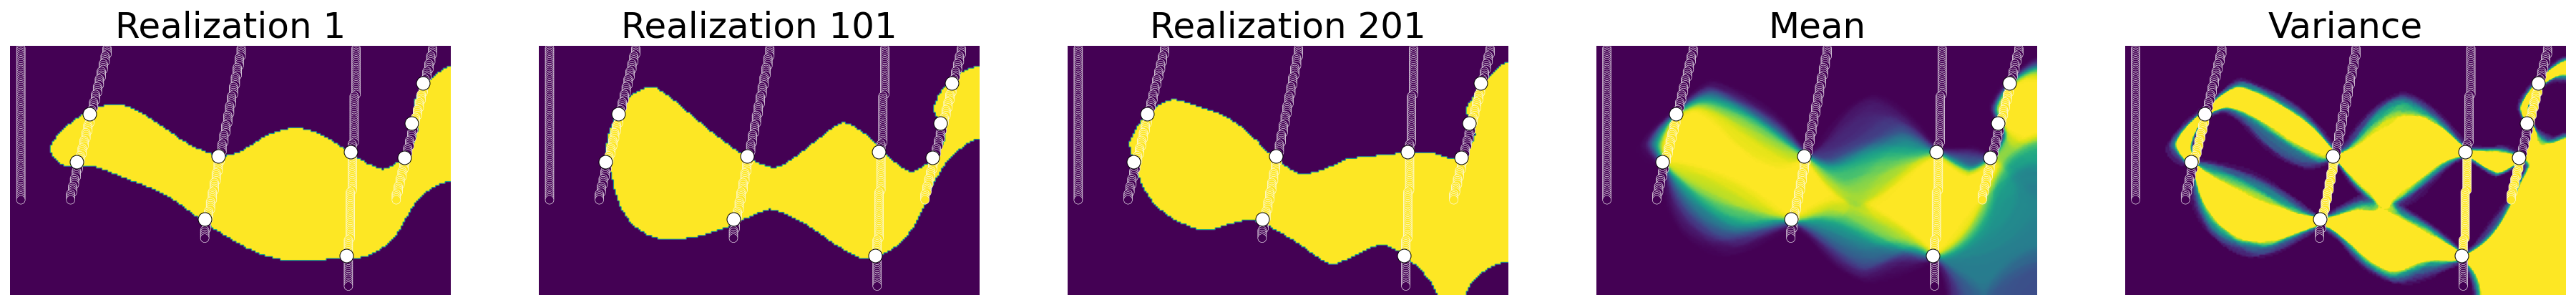

In [455]:
vis_ensembles_mean_var((mc_pos_sdf_selected>0)*1)

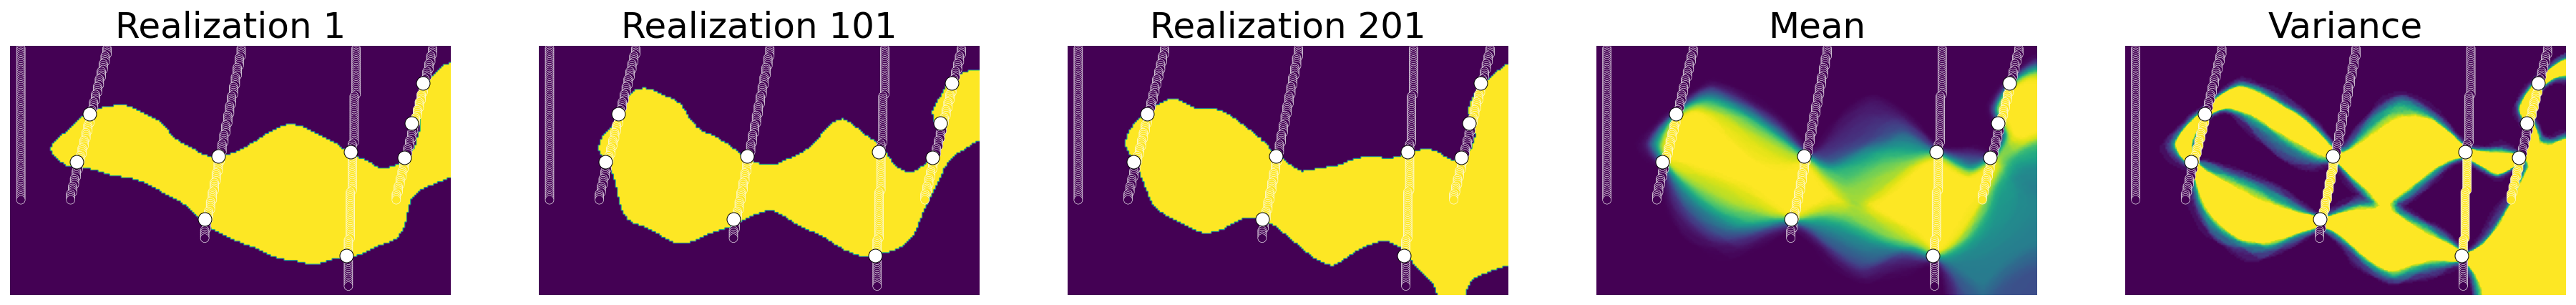

In [456]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT>0.5)*1)

In [457]:
mc_pos_sdf_plus_residual_S_DT_pos = mc_pos_sdf_plus_residual_S_DT_pos.reshape(mc_pos_sdf_selected.shape)

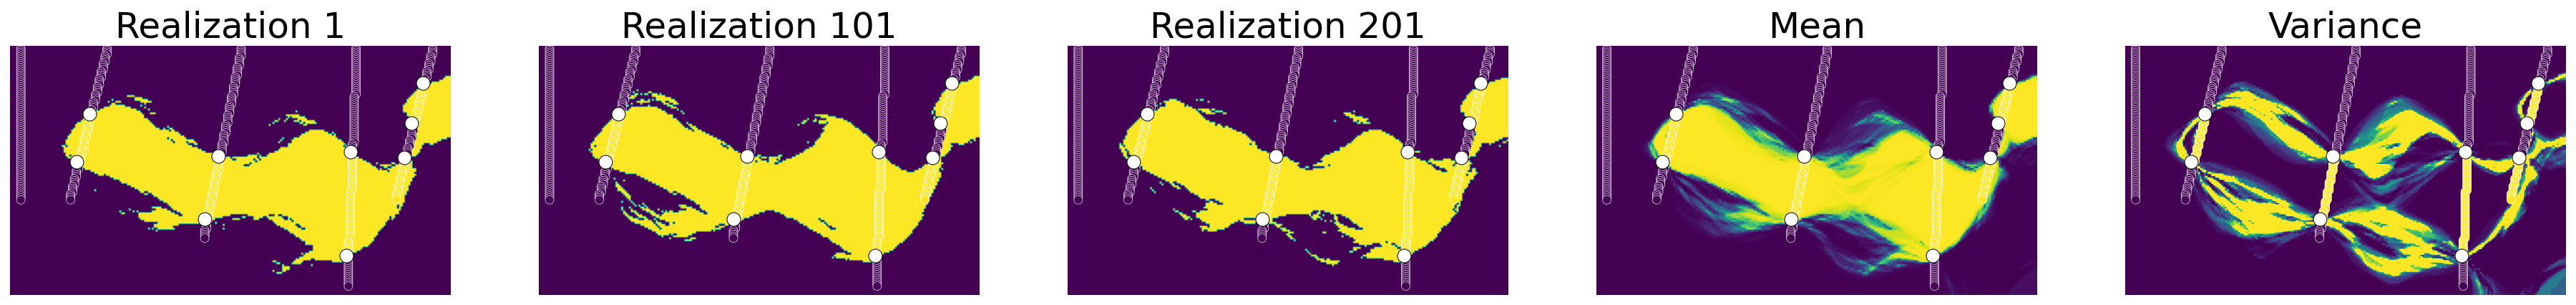

In [458]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT_pos>0.5)*1)

In [459]:
plus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==1]
minus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==0]

(array([  0.,   0.,   0.,   0.,   0., 280.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

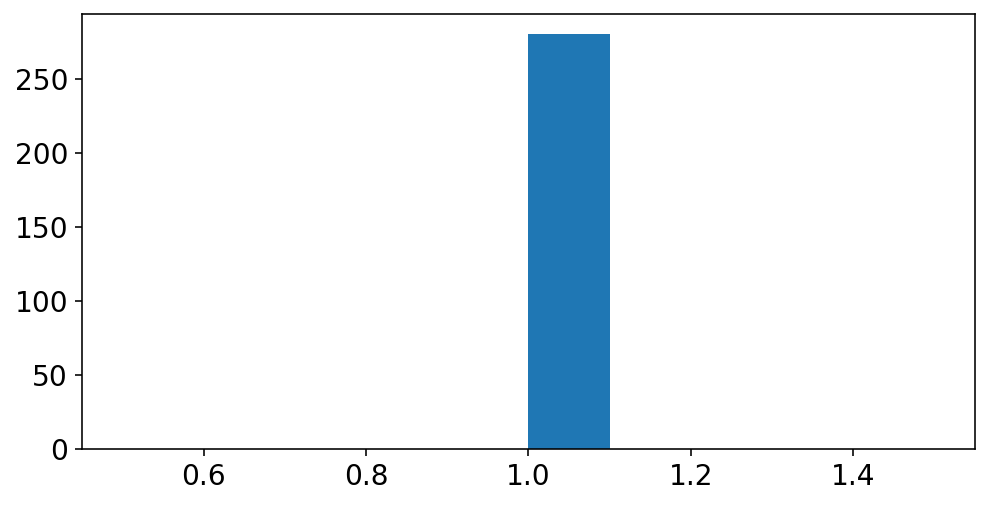

In [460]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0.5,axis = 1)+np.sum(minus_pos<=0.5,axis = 1))/(np.sum(data==0)+np.sum(data==1)))